# Ducktile
## Introduction to TileDB and DuckDB

## 🀙 TileDB

Make imports, then we'll set up the domain and schema for our sparse array.
We are going to record temperature changes over time.

In [1]:
import pandas as pd
import tiledb
import numpy as np

# Define the maximum value for int64
max_int64 = np.iinfo(np.int64).max
tile_extent = 1000

# Calculate the safe domain max to avoid overflow
# Ensure domain_max + tile_extent <= max_int64
safe_domain_max = max_int64 - tile_extent

# Define the domain and schema for a sparse array
dom = tiledb.Domain(
    tiledb.Dim(name="timestamp", domain=(0, safe_domain_max), tile=tile_extent, dtype=np.int64),
    tiledb.Dim(name="latitude", domain=(-90.0, 90.0), tile=1.0, dtype=np.float64),
    tiledb.Dim(name="longitude", domain=(-180.0, 180.0), tile=1.0, dtype=np.float64),
    tiledb.Dim(name="altitude", domain=(0, 10000), tile=100, dtype=np.float64)
)

schema = tiledb.ArraySchema(
    domain=dom, sparse=True, attrs=[tiledb.Attr(name="temperature", dtype=np.float32)]
)

# Create the array
array_name = "temperature_data"
tiledb.SparseArray.create(array_name, schema)


In [2]:
# Sample data
timestamps = np.array([1622505600, 1622592000, 1622678400], dtype=np.int64)  # Unix timestamps
latitudes = np.array([40.7128, 40.7128, 40.7128], dtype=np.float64)  # New York City latitude
longitudes = np.array([-74.0060, -74.0060, -74.0060], dtype=np.float64)  # New York City longitude
altitudes = np.array([10, 10, 10], dtype=np.float64)  # Altitude in meters
temperatures = np.array([22.5, 23.0, 21.5], dtype=np.float32)  # Temperatures in Celsius

# Write data to the array
with tiledb.SparseArray(array_name, mode='w') as A:
    A[timestamps, latitudes, longitudes, altitudes] = {"temperature": temperatures}


In [3]:
# Define the time range and location for the query
start_time = 1622505600
end_time = 1622678400
latitude = 40.7128
longitude = -74.0060
altitude = 10

# Query the array
with tiledb.SparseArray(array_name, mode='r') as A:
    data = A.query(attrs=["temperature"]).multi_index[start_time:end_time, latitude, longitude, altitude]
    df = pd.DataFrame({
        "timestamp": data["timestamp"],
        "temperature": data["temperature"]
    })
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit='s')
    print(df)


   timestamp  temperature
0 2021-06-01         22.5
1 2021-06-02         23.0
2 2021-06-03         21.5


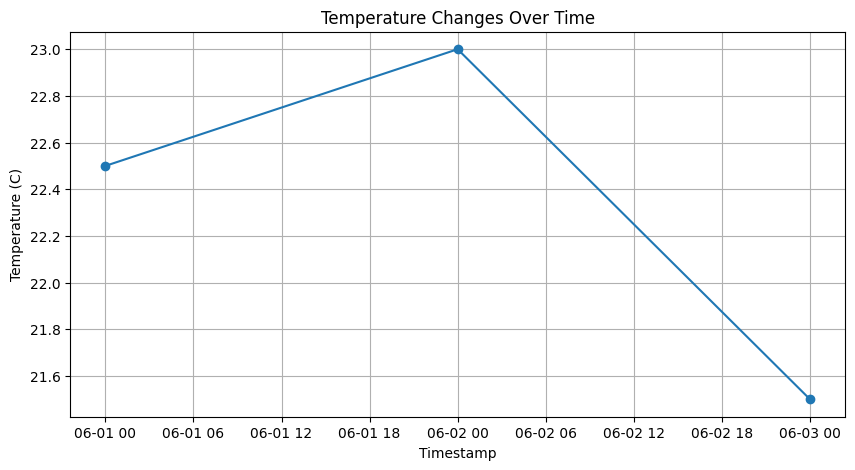

In [4]:
import matplotlib.pyplot as plt

# Plot the temperature changes over time
plt.figure(figsize=(10, 5))
plt.plot(df["timestamp"], df["temperature"], marker='o')
plt.title("Temperature Changes Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Temperature (C)")
plt.grid(True)
plt.show()


Want to go further? Try out tiledb's [time travel](https://docs.tiledb.com/main/how-to/arrays/reading-arrays/time-traveling) feature.

example from docs:

```python
timestamp = 1561492235844 # time in ms

# `tiledb.open` supports the `timestamp` keyword argument
A = tiledb.open(uri, timestamp=timestamp)

# `timestamp` may also be specified as a (start, end) tuple
A = tiledb.open(uri, timestamp=(start_ts, end_ts))
```

## 🦆DuckDB

In [5]:
import pandas as pd

# Create the initial DataFrame based on our previous data
temperature_data = pd.DataFrame({
    'timestamp': [1622548800, 1622548860, 1622548920],
    'latitude': [40.7128, 34.0522, 41.8781],
    'longitude': [-74.0060, -118.2437, -87.6298],
    'altitude': [10.0, 20.0, 15.0],
    'temperature': [22.5, 25.0, 23.0]
})

temperature_data

,timestamp,latitude,longitude,altitude,temperature
0,1622548800,40.7128,-74.0060,10.0,22.5
1,1622548860,34.0522,-118.2437,20.0,25.0
2,1622548920,41.8781,-87.6298,15.0,23.0


But now let's add a relationship

In [6]:
# Create a new DataFrame for location metadata
location_metadata = pd.DataFrame({
    'location_id': [1, 2, 3],
    'latitude': [40.7128, 34.0522, 41.8781],
    'longitude': [-74.0060, -118.2437, -87.6298],
    'city': ['New York', 'Los Angeles', 'Chicago']
})

# Merge the temperature data with location metadata
temperature_data = temperature_data.merge(location_metadata, on=['latitude', 'longitude'])

temperature_data


,timestamp,latitude,longitude,altitude,temperature,location_id,city
0,1622548800,40.7128,-74.0060,10.0,22.5,1,New York
1,1622548860,34.0522,-118.2437,20.0,25.0,2,Los Angeles
2,1622548920,41.8781,-87.6298,15.0,23.0,3,Chicago


Use duckdb to query and manipulate the data

In [7]:
import duckdb

# Connect to an in-memory DuckDB instance
con = duckdb.connect()

# Load the DataFrame into DuckDB
con.register('temperature_data', temperature_data)

# Perform a query to get the average temperature by city
query = """
SELECT city, AVG(temperature) as avg_temperature
FROM temperature_data
GROUP BY city
"""

result = con.execute(query).fetchdf()
result


,city,avg_temperature
0,New York,22.5
1,Los Angeles,25.0
2,Chicago,23.0


### DuckDB + DataViz

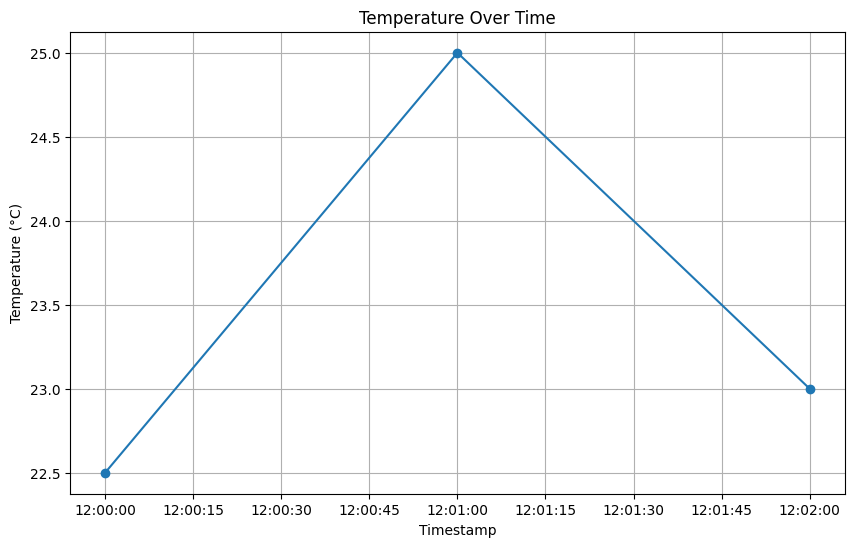

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the initial DataFrame
temperature_data = pd.DataFrame({
    'timestamp': [1622548800, 1622548860, 1622548920],
    'latitude': [40.7128, 34.0522, 41.8781],
    'longitude': [-74.0060, -118.2437, -87.6298],
    'altitude': [10.0, 20.0, 15.0],
    'temperature': [22.5, 25.0, 23.0]
})

# Convert timestamp to datetime
temperature_data['timestamp'] = pd.to_datetime(temperature_data['timestamp'], unit='s')

# Plot temperature over time
plt.figure(figsize=(10, 6))
plt.plot(temperature_data['timestamp'], temperature_data['temperature'], marker='o')
plt.title('Temperature Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()


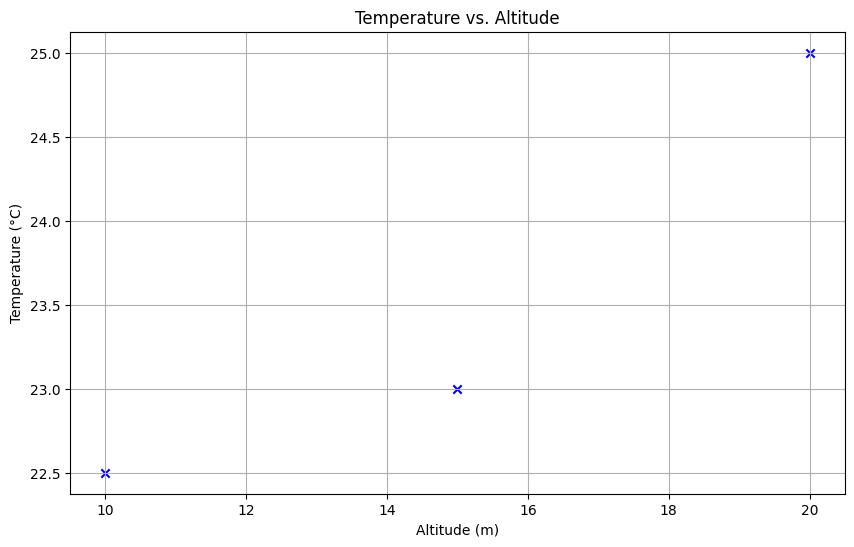

In [9]:
# Scatter plot of temperature vs. altitude
plt.figure(figsize=(10, 6))
plt.scatter(temperature_data['altitude'], temperature_data['temperature'], c='blue', marker='x')
plt.title('Temperature vs. Altitude')
plt.xlabel('Altitude (m)')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()


<Figure size 1000x600 with 0 Axes>

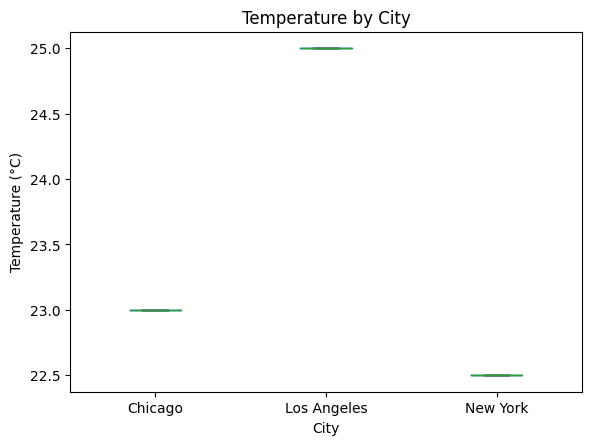

In [10]:
import duckdb

# Create a new DataFrame for location metadata
location_metadata = pd.DataFrame({
    'location_id': [1, 2, 3],
    'latitude': [40.7128, 34.0522, 41.8781],
    'longitude': [-74.0060, -118.2437, -87.6298],
    'city': ['New York', 'Los Angeles', 'Chicago']
})

# Merge the temperature data with location metadata
temperature_data = temperature_data.merge(location_metadata, on=['latitude', 'longitude'])

# Use DuckDB to query the data
con = duckdb.connect()
con.register('temperature_data', temperature_data)

query = """
SELECT city, temperature
FROM temperature_data
"""

result = con.execute(query).fetchdf()

# Box plot of temperature by city
plt.figure(figsize=(10, 6))
result.boxplot(by='city', column=['temperature'], grid=False)
plt.title('Temperature by City')
plt.suptitle('')  # Suppress the default title
plt.xlabel('City')
plt.ylabel('Temperature (°C)')
plt.show()


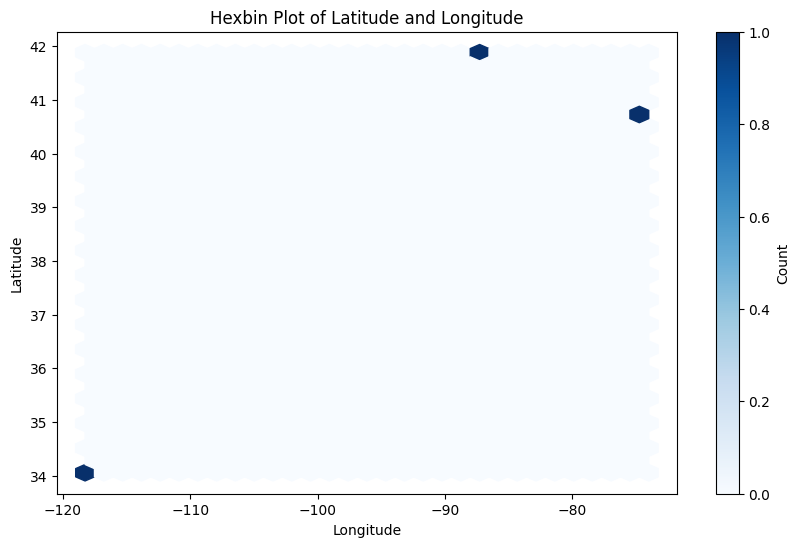

In [11]:
# Hexbin plot of latitude and longitude
plt.figure(figsize=(10, 6))
plt.hexbin(temperature_data['longitude'], temperature_data['latitude'], gridsize=30, cmap='Blues')
plt.colorbar(label='Count')
plt.title('Hexbin Plot of Latitude and Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
